# Memory-based CF

In [ ]:
!pip install surprise

     |████████████████████████████████| 3.3MB 1.4MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.0.6-cp36-cp36m-linux_x86_64.whl size=1683515 sha256=0b6b4eb7c86db1a1389bb5bac8ecc4ce34a430f0ac21bd03a6ad3e3ec060a24f
  Stored in directory: /root/.cache/pip/wheels/ec/c0/55/3a28eab06b53c220015063ebbdb81213cd3dcbb72c088251ec
Successfully built scikit-surprise


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import os, math, random
import numpy as np
import pandas as pd
from sklearn import datasets, preprocessing, model_selection, metrics
import surprise as sp

seed = 0
random.seed(seed)
np.random.seed(seed)

# 데이터
sp_data = sp.Dataset.load_builtin('ml-100k')
df_data = pd.DataFrame(sp_data.raw_ratings, columns=["user_id", "item_id", "rating", "timestamp"])
print("df_data.shape={}".format(df_data.shape))
print(df_data.dtypes)
print(df_data.head())
print(df_data.describe(include='all'))

df_train, df_test = model_selection.train_test_split(df_data, test_size=0.1)
print(df_data.shape, df_train.shape, df_test.shape)

# 전처리 
# A reader is still needed but only the rating_scale param is requiered.
reader = sp.Reader(rating_scale=(1, 5))
sp_data = sp.Dataset.load_from_df(df_train[['user_id', 'item_id', 'rating']], reader)
# surprise model.test 의 input shape => [(user_id, item_id, rating)]
sp_test = [(row['user_id'], row['item_id'], row['rating']) for i, row in df_test.iterrows()]

# 모델
models = [
    sp.KNNBasic(sim_options={'name' : 'msd'}), 
    sp.KNNBasic(sim_options={'name' : 'cosine'}),
    sp.KNNBasic(sim_options={'name' : 'pearson'}),
    sp.KNNBasic(sim_options={'name' : 'msd', 'user_based': False}),
    sp.KNNBasic(sim_options={'name' : 'cosine', 'user_based': False}),
    sp.KNNBasic(sim_options={'name' : 'pearson', 'user_based': False})    
]

for model in models:
    # 학습
    sp.model_selection.cross_validate(model, sp_data, measures=['RMSE', 'MAE'], cv=3, verbose=True)
    
    # 평가
    sp_pred = model.test(sp_test)
    rmse = sp.accuracy.rmse(sp_pred, verbose=False)
    print("Test RMSE={}".format(rmse))

Dataset ml-100k could not be found. Do you want to download it? [Y/n] y
Trying to download dataset from http://files.grouplens.org/datasets/movielens/ml-100k.zip...
Done! Dataset ml-100k has been saved to /root/.surprise_data/ml-100k
df_data.shape=(100000, 4)
user_id       object
item_id       object
rating       float64
timestamp     object
dtype: object
  user_id item_id  rating  timestamp
0     196     242     3.0  881250949
1     186     302     3.0  891717742
2      22     377     1.0  878887116
3     244      51     2.0  880606923
4     166     346     1.0  886397596
       user_id item_id         rating  timestamp
count   100000  100000  100000.000000     100000
unique     943    1682            NaN      49282
top        405      50            NaN  891033606
freq       737     583            NaN         12
mean       NaN     NaN       3.529860        NaN
std        NaN     NaN       1.125674        NaN
min        NaN     NaN       1.000000        NaN
25%        NaN     NaN      

In [ ]:
# 평가: by predict
tests = []
preds = []
for row in sp_test:
    tests.append(row[2])
    pred = model.predict(row[0], row[1], row[2])
    preds.append(pred.est)

rmse = math.sqrt(metrics.mean_squared_error(tests, preds))
print("Test RMSE={}".format(rmse))

Test RMSE=1.051538692275093


In [ ]:
print("Top-N Similar Users")
user_model = models[0] # sp.KNNBasic(sim_options={'name' : 'msd'})
raw_uid = '22'
inner_uid = user_model.trainset.to_inner_uid(raw_uid)
raw_uid = user_model.trainset.to_raw_uid(inner_uid)
print("raw_uid:{} == inner_uid:{}".format(raw_uid, inner_uid))

top_inner_uids = user_model.get_neighbors(inner_uid, k=5)
print("top-5 inner_uids: {}".format(top_inner_uids))
top_raw_uids = [user_model.trainset.to_raw_uid(top_inner_uid) for top_inner_uid in top_inner_uids]
print("top-5 raw_uids: {}".format(top_raw_uids))

print("\nTop-N Similar Items")
item_model = models[3] # sp.KNNBasic(sim_options={'name' : 'msd', 'user_based': False})
raw_iid = '377'
inner_iid = item_model.trainset.to_inner_iid(raw_iid)
raw_iid = item_model.trainset.to_raw_iid(inner_iid)
print("raw_iid:{} == inner_iid:{}".format(raw_iid, inner_iid))

top_inner_iids = item_model.get_neighbors(inner_iid, k=5)
print("top-5 inner_iids: {}".format(top_inner_iids))
top_raw_iids = [item_model.trainset.to_raw_iid(top_inner_iid) for top_inner_iid in top_inner_iids]
print("top-5 raw_iids: {}".format(top_raw_iids))

Top-N Similar Users
raw_uid:22 == inner_uid:493
top-5 inner_uids: [3, 32, 85, 100, 174]
top-5 raw_uids: ['803', '703', '494', '787', '802']

Top-N Similar Items
raw_iid:377 == inner_iid:610
top-5 inner_iids: [1, 15, 30, 47, 56]
top-5 raw_iids: ['597', '402', '356', '365', '406']


# Model-based CF

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import os, math
import numpy as np
import pandas as pd
from sklearn import datasets, preprocessing, model_selection, metrics
import surprise as sp

# 데이터
sp_data = sp.Dataset.load_builtin('ml-100k')
df_data = pd.DataFrame(sp_data.raw_ratings, columns=["user_id", "item_id", "rating", "timestamp"])
print("df_data.shape={}".format(df_data.shape))
print(df_data.dtypes)
print(df_data.head())
print(df_data.describe(include='all'))

df_train, df_test = model_selection.train_test_split(df_data, test_size=0.1)
print(df_data.shape, df_train.shape, df_test.shape)

# 전처리 
# A reader is still needed but only the rating_scale param is requiered.
reader = sp.Reader(rating_scale=(1, 5))
sp_data = sp.Dataset.load_from_df(df_train[['user_id', 'item_id', 'rating']], reader)
# surprise model.test 의 input shape => [(user_id, item_id, rating)]
sp_test = [(row['user_id'], row['item_id'], row['rating']) for i, row in df_test.iterrows()]

# 모델
models = [
    sp.SVD(n_factors=10),    
]

for model in models:
    # 학습
    sp.model_selection.cross_validate(model, sp_data, measures=['RMSE', 'MAE'], cv=3, verbose=True)
    
    # 평가
    sp_pred = model.test(sp_test)
    rmse = sp.accuracy.rmse(sp_pred, verbose=False)
    print("Test RMSE={}".format(rmse))

df_data.shape=(100000, 4)
user_id       object
item_id       object
rating       float64
timestamp     object
dtype: object
  user_id item_id  rating  timestamp
0     196     242     3.0  881250949
1     186     302     3.0  891717742
2      22     377     1.0  878887116
3     244      51     2.0  880606923
4     166     346     1.0  886397596
       user_id item_id         rating  timestamp
count   100000  100000  100000.000000     100000
unique     943    1682            NaN      49282
top        405      50            NaN  891033606
freq       737     583            NaN         12
mean       NaN     NaN       3.529860        NaN
std        NaN     NaN       1.125674        NaN
min        NaN     NaN       1.000000        NaN
25%        NaN     NaN       3.000000        NaN
50%        NaN     NaN       4.000000        NaN
75%        NaN     NaN       4.000000        NaN
max        NaN     NaN       5.000000        NaN
(100000, 4) (90000, 4) (10000, 4)
Evaluating RMSE, MAE of algorith

In [ ]:
# 평가: by predict
tests = []
preds = []
for row in sp_test:
    tests.append(row[2])
    pred = model.predict(row[0], row[1], row[2])
    preds.append(pred.est)

rmse = math.sqrt(metrics.mean_squared_error(tests, preds))
print("Test RMSE={}".format(rmse))

Test RMSE=0.9463626341382563


# Deep MF

Using TensorFlow backend.


df_data.shape=(100000, 4)
user_id       object
item_id       object
rating       float64
timestamp     object
dtype: object
  user_id item_id  rating  timestamp
0     196     242     3.0  881250949
1     186     302     3.0  891717742
2      22     377     1.0  878887116
3     244      51     2.0  880606923
4     166     346     1.0  886397596
       user_id item_id         rating  timestamp
count   100000  100000  100000.000000     100000
unique     943    1682            NaN      49282
top        405      50            NaN  891033606
freq       737     583            NaN         12
mean       NaN     NaN       3.529860        NaN
std        NaN     NaN       1.125674        NaN
min        NaN     NaN       1.000000        NaN
25%        NaN     NaN       3.000000        NaN
50%        NaN     NaN       4.000000        NaN
75%        NaN     NaN       4.000000        NaN
max        NaN     NaN       5.000000        NaN
np_data_xs.shape=(100000, 2)
np_data_ys.shape=(100000,)


W0811 10:00:38.605398 139797586540416 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0811 10:00:38.648448 139797586540416 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0811 10:00:38.693752 139797586540416 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0811 10:00:38.708461 139797586540416 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



n_users=943, n_items=1682, n_factors=3
train shape: np_train_xs=(70000, 2), np_train_ys=(70000,)
test shape: np_test_xs=(30000, 2), np_test_ys=(30000,)
np_train_x_user_ids.shape=(70000,)
np_train_x_item_ids.shape=(70000,)
np_train_x_user_ids.shape=(30000,)
np_train_x_item_ids.shape=(30000,)

model
Test RMSE=1.1220312873819274

model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
user_embed (Embedding)          (None, 1, 3)         2832        user_i

W0811 10:00:38.909032 139797586540416 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0811 10:00:38.951178 139797586540416 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



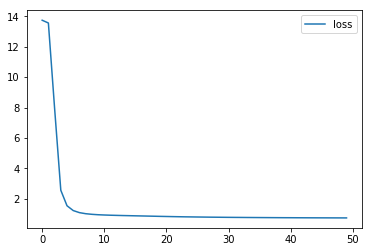

Test RMSE=0.942572657044128


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import os, math, random
import numpy as np
import pandas as pd
from sklearn import datasets, preprocessing, model_selection, metrics, dummy
import surprise as sp
from keras import models, layers, optimizers, utils

seed = 0
random.seed(seed)
np.random.seed(seed)

# 데이터
sp_data = sp.Dataset.load_builtin('ml-100k')
df_data = pd.DataFrame(sp_data.raw_ratings, columns=["user_id", "item_id", "rating", "timestamp"])
print("df_data.shape={}".format(df_data.shape))
print(df_data.dtypes)
print(df_data.head())
print(df_data.describe(include='all'))

# user_id = df_data.user_id.astype('category').cat.codes.values
# item_id = df_data.item_id.astype('category').cat.codes.values
# print(user_id.shape)

np_data_xs = df_data[["user_id", "item_id"]].astype('category').values
np_data_ys = df_data["rating"].values
print("np_data_xs.shape={}".format(np_data_xs.shape))
print("np_data_ys.shape={}".format(np_data_ys.shape))

n_users = len(np.unique(np_data_xs[:, 0]))
n_items = len(np.unique(np_data_xs[:, 1]))
n_factors = 3
print("n_users={}, n_items={}, n_factors={}".format(n_users, n_items, n_factors))

np_train_xs, np_test_xs, np_train_ys, np_test_ys = model_selection.train_test_split(
    np_data_xs, np_data_ys, 
    test_size=0.3, shuffle=True, random_state=2)
print("train shape: np_train_xs={}, np_train_ys={}".format(np_train_xs.shape, np_train_ys.shape))
print("test shape: np_test_xs={}, np_test_ys={}".format(np_test_xs.shape, np_test_ys.shape))

np_train_x_user_ids = np_train_xs[:, 0].reshape(-1)
np_train_x_item_ids = np_train_xs[:, 1].reshape(-1)
print("np_train_x_user_ids.shape={}".format(np_train_x_user_ids.shape))
print("np_train_x_item_ids.shape={}".format(np_train_x_item_ids.shape))

np_test_x_user_ids = np_test_xs[:, 0].reshape(-1)
np_test_x_item_ids = np_test_xs[:, 1].reshape(-1)
print("np_train_x_user_ids.shape={}".format(np_test_x_user_ids.shape))
print("np_train_x_item_ids.shape={}".format(np_test_x_item_ids.shape))

# 모델
class DeepMF(models.Model):
    def __init__(self, n_users, n_items, n_factors):
        # multi input/output 을 위해서는 name 지정이 필요
        user_input = layers.Input(shape=[1], name='user_input')
        user_embed = layers.Embedding(n_users+1, n_factors, name='user_embed')(user_input)
        user_vec = layers.Flatten(name='user_vec')(user_embed)
        
        item_input = layers.Input(shape=[1], name='item_input')
        item_embed = layers.Embedding(n_items+1, n_factors, name='item_embed')(item_input)
        item_vec = layers.Flatten(name='item_vec')(item_embed)
        
        dot_vec = layers.dot([user_vec, item_vec], axes=1, name='dot_vec')
        
        super().__init__(inputs=[user_input, item_input], outputs=[dot_vec])
        sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
        self.compile(optimizer=sgd, loss='mean_squared_error', metrics=['mse', 'mae'])


models = [
    dummy.DummyRegressor(strategy='mean'),  
    DeepMF(n_users = n_users, n_items = n_items, n_factors=3)    
]

for model in models:
    # 학습
    print("\nmodel")
    model_type = str(type(model))
    if model_type.find("DummyRegressor") > -1:
        model.fit(np_train_xs, np_train_ys)
        # 평가
        np_pred_ys = model.predict(np_test_xs)        
    else:
        model.summary()

        history = model.fit([np_train_x_user_ids, np_train_x_item_ids], np_train_ys, epochs=50, verbose=0)
        plt.plot(history.history['loss'], label='loss')
        plt.legend()
        plt.show()    

        # 평가
        np_pred_ys = model.predict([np_test_x_user_ids, np_test_x_item_ids])

    rmse = math.sqrt(metrics.mean_squared_error(np_test_ys, np_pred_ys))
    print("Test RMSE={}".format(rmse))     